# Rain in Australia: Predict rain tomorrow in Australia

# A. Creating Spark Session and Loading the Data

## Step 1: Import Spark Session and initialize Spark

In [1]:
# Import PySpark
import pyspark

In [2]:
import os
os.environ["PYSPARK_PYTHON"]="/usr/local/bin/python3"

In [3]:
# Create the SparkContext which acts as the main entry point for Spark Core functionality
# Create the SparkConf object that contains information about the application
# The jar package is required to install in SparkConf to make sure SparkContext & SparkSession run smoothly
# In my system, the jar package will be installed for Spark  2.4.3 and Scala 2.11.12
from pyspark import SparkConf, SparkContext
conf = SparkConf()\
.setAppName("rain_prediction")\
.setMaster("local[4]")

# Create the SparkSession object
# The port number of Mongodb is included in the conection line (27017)
from pyspark.sql import SparkSession
spark = SparkSession\
.builder\
.config(conf = conf)\
.config("spark.mongodb.input.uri", "mongodb://127.0.0.1:27017/rain_in_aus")\
.config("spark.mongodb.output.uri", "mongodb://127.0.0.1:27017/rain_in_aus")\
.getOrCreate()

In [4]:
# Import other statements
from pyspark.sql.functions import col, avg, when, countDistinct
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [5]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

## Step 2: Load the dataset and print the schema and total number of entries

In [6]:
# Load the data as the CSV file
dataset = spark.read.csv('weatherAUS.csv',
                        header = True)

In [7]:
# Print the total number of entries in the CSV file
print('The total number of entries in the CSV file is', dataset.count())

The total number of entries in the CSV file is 142193


# B. Data Cleaning and Processing

## Step 3: Delete columns from the dataset

In [8]:
# Show the dataset before removing some columns
dataset.show(5, truncate = False)

+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Date      |Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01|Albury  |13.4   |22.9   |0.6     |NA         |NA      |W          |44           |W         |WNW       |20          |24          |71         |22         |1007.7     |1007.1     |8       |NA      |16.9   |21.8   |No       |No          |
|2008-12-02|

In [9]:
## Delete 'Date', 'Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm' column from the dataset
dataset = dataset.\
select([column for column in dataset.columns if column not in {'Date', 'Location', 'Evaporation', 
                                                               'Sunshine', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'}])

In [10]:
# Show the dataset after removing some columns
dataset.show(5)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|       0|        WNW|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|       0|        WSW|           46|         W|       WSW|          19|          26|         38|         30|     1007.6|    

## Step 4: Print the number of missing data in each column

In [11]:
#Return a list containing the name of columns
col_name = dataset.columns
col_name

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'RainToday',
 'RainTomorrow']

In [12]:
# Create a function that counts the null values in each column from the dataset
def count_null_values(col_name):
    return dataset.where(col(col_name) == 'NA').count()

In [13]:
# Print the number of null values in each column from the dataset
for column in col_name:
    print('The number of null values in {0}: {1}'.format(column, count_null_values(column)))

The number of null values in MinTemp: 637
The number of null values in MaxTemp: 322
The number of null values in Rainfall: 1406
The number of null values in WindGustDir: 9330
The number of null values in WindGustSpeed: 9270
The number of null values in WindDir9am: 10013
The number of null values in WindDir3pm: 3778
The number of null values in WindSpeed9am: 1348
The number of null values in WindSpeed3pm: 2630
The number of null values in Humidity9am: 1774
The number of null values in Humidity3pm: 3610
The number of null values in Pressure9am: 14014
The number of null values in Pressure3pm: 13981
The number of null values in RainToday: 1406
The number of null values in RainTomorrow: 0


## Step 5: Fill the missing data with average value and maximum occurrence value

In [14]:
# Check the type of value in the dataset
dataset.dtypes

[('MinTemp', 'string'),
 ('MaxTemp', 'string'),
 ('Rainfall', 'string'),
 ('WindGustDir', 'string'),
 ('WindGustSpeed', 'string'),
 ('WindDir9am', 'string'),
 ('WindDir3pm', 'string'),
 ('WindSpeed9am', 'string'),
 ('WindSpeed3pm', 'string'),
 ('Humidity9am', 'string'),
 ('Humidity3pm', 'string'),
 ('Pressure9am', 'string'),
 ('Pressure3pm', 'string'),
 ('RainToday', 'string'),
 ('RainTomorrow', 'string')]

In [15]:
# Show the dataset
dataset.show(5)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|       0|        WNW|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|       0|        WSW|           46|         W|       WSW|          19|          26|         38|         30|     1007.6|    

### 5.1. Identify the columns which have numeric values, calculate the average and fill the null value with the aveage

In [16]:
# Create a list that contains the name of columns having numeric values
num_col = ['MinTemp',
          'MaxTemp',
          'Rainfall',
          'WindGustSpeed',
          'WindSpeed9am',
          'WindSpeed3pm',
          'Humidity9am',
          'Humidity3pm',
          'Pressure9am',
          'Pressure3pm']

In [17]:
# Create a function that calculates the average value of numeric columns
def calculate_avg_val(col_name):
    avg_val = dataset.agg(avg(col(col_name))).collect()[0][0]
    return avg_val

In [18]:
# Fill null values in each numeric columns by the average value
for col_name in num_col:
    dataset = dataset.withColumn(col_name, \
                                 when(dataset[col_name] == 'NA',\
                                      calculate_avg_val(col_name)).otherwise(dataset[col_name]))

In [19]:
# Show the dataset after filling null values
dataset.show(truncate = False)

+-------+-------+------------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall          |WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am   |WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+------------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|13.4   |22.9   |0.6               |W          |44           |W         |WNW       |20             |24          |71         |22         |1007.7     |1007.1     |No       |No          |
|7.4    |25.1   |0                 |WNW        |44           |NNW       |WSW       |4              |22          |44         |25         |1010.6     |1007.8     |No       |No          |
|12.9   |25.7   |0                 |WSW        |46           |W         |WS

### 5.2. Identify the columns which have non-numeric values and find the most frequent item. Fill the null values with that item for that particular column.

In [20]:
# Create a list that contains the name of columns having non_numeric values
non_num_col = ['WindGustDir',
              'WindDir9am',
              'WindDir3pm',
              'RainToday',
              'RainTomorrow']

In [21]:
def calculate_freq_val(col_name):
    order_data = dataset.groupBy(col_name).count()
    most_freq_val = order_data.select(col_name).where(col('count') == \
                                                       order_data.sort(col('count').desc()).\
                                                       select('count').collect()[0][0]).collect()[0][0] 
    return most_freq_val

In [22]:
# Fill null values in each non-numeric columns by the most frequent value
for col_name in non_num_col:
    dataset = dataset.withColumn(col_name, \
                                 when(dataset[col_name] == 'NA',\
                                      calculate_freq_val(col_name)).otherwise(dataset[col_name]))

In [23]:
# Show the dataset after filling null values
dataset.show()

+-------+-------+------------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|          Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|   WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+------------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|               0.6|          W|           44|         W|       WNW|             20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|                 0|        WNW|           44|       NNW|       WSW|              4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|                 0|        WSW|           46|         W|  

## Step 6: Data Transformation

### 6.1. Transform numerical data 

In [24]:
# Convert values of numeric columns from the 'string' type into the 'double' type
for col_name in num_col:
    dataset = dataset.withColumn(col_name, col(col_name).cast('double'))

In [25]:
# Show the dataset after transforming numerical data
dataset.show()

+-------+-------+------------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|          Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|   WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+------------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|               0.6|          W|         44.0|         W|       WNW|           20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|               0.0|        WNW|         44.0|       NNW|       WSW|            4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|               0.0|        WSW|         46.0|         W|  

### 6.2. Transform non-numerical data 

In [26]:
# Create a list that contains the name of columns having non_numeric values
non_num_col = ['WindGustDir',
              'WindDir9am',
              'WindDir3pm',
              'RainToday',
              'RainTomorrow']

In [27]:
# Create a list of index for each value of each non-numerical column
# The Estimator implements the method fit() in the dataset
indexers = [StringIndexer(inputCol = col_name,
                         outputCol = col_name + '_index').\
            fit(dataset) for col_name in non_num_col]

In [28]:
# Create a Pipeline consisting of a sequence of stages which are indexs created from the list above
pipeline = Pipeline(stages = indexers)

In [29]:
# The fitted model from the Pipeline which consists of fitted models and transformers, corresponding to the pipeline stages
# The Transformer implements the method transform() which converts the dataframe into another, 
# by appending index columns predicted from the 'fit' model
dataset = pipeline.fit(dataset).transform(dataset)

In [30]:
# Drop non-numerical columns in the dataset
dataset = dataset.drop('WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow')

In [31]:
# Show the dataset after transforming non-numerical data
dataset.show(5)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------------+----------------+----------------+---------------+------------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDir_index|WindDir9am_index|WindDir3pm_index|RainToday_index|RainTomorrow_index|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------------+----------------+----------------+---------------+------------------+
|   13.4|   22.9|     0.6|         44.0|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|              0.0|             6.0|             7.0|            0.0|               0.0|
|    7.4|   25.1|     0.0|         44.0|         4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|              9.0|             9.0|             3.0|            0.0|          

## Step 07: Create the feature vector and divide the dataset 

### 7.1. Create the feature vector

In [32]:
dataset.dtypes

[('MinTemp', 'double'),
 ('MaxTemp', 'double'),
 ('Rainfall', 'double'),
 ('WindGustSpeed', 'double'),
 ('WindSpeed9am', 'double'),
 ('WindSpeed3pm', 'double'),
 ('Humidity9am', 'double'),
 ('Humidity3pm', 'double'),
 ('Pressure9am', 'double'),
 ('Pressure3pm', 'double'),
 ('WindGustDir_index', 'double'),
 ('WindDir9am_index', 'double'),
 ('WindDir3pm_index', 'double'),
 ('RainToday_index', 'double'),
 ('RainTomorrow_index', 'double')]

In [33]:
# Create a Transformer that combines a given list of columns into a single vector column
# Except non-numerical columns, the feature vector is created from all columns 
# in the dataframe except non-numerical columns and 'RainTomorrow_index' column
assembler = VectorAssembler(
inputCols = list(set(dataset.columns) - set(['RainTomorrow_index'])),
outputCol = 'FeatureVector')

In [34]:
# Return the new dataset by adding the feature vector column
dataset = assembler.transform(dataset)

In [35]:
dataset.columns

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'WindGustDir_index',
 'WindDir9am_index',
 'WindDir3pm_index',
 'RainToday_index',
 'RainTomorrow_index',
 'FeatureVector']

In [36]:
# Show the dataset that contains only two columns including 'RainTomorrow_index' and 'FeatureVector'
new_df = dataset.select(*('RainTomorrow_index', 'FeatureVector'))
new_df.show(5)

+------------------+--------------------+
|RainTomorrow_index|       FeatureVector|
+------------------+--------------------+
|               0.0|[1007.1,44.0,22.0...|
|               0.0|[1007.8,44.0,25.0...|
|               0.0|[1008.7,46.0,30.0...|
|               0.0|[1012.8,24.0,16.0...|
|               0.0|[1006.0,41.0,33.0...|
+------------------+--------------------+
only showing top 5 rows



### 7.2. Split the dataset

In [37]:
# Split the dataset randomly between 70% and 30%
(trainingData, testData) = new_df.randomSplit([0.7, 0.3])

# C. Apply Machine Learning Algorithms

## Step 8: Apply machine learning classification algorithms on the dataset and compare their accuracy. Plot the accuracy as bar graph. 

### 8.1. Run and calculate the accuracy of decision tree classifier

In [38]:
# Predict the values of RainTomorrow_index by the Decision Tree Classifier model
dt = DecisionTreeClassifier(labelCol="RainTomorrow_index", featuresCol="FeatureVector")
dt_model = dt.fit(trainingData)
dt_predictions = dt_model.transform(testData)
dt_predictions.select('prediction', "RainTomorrow_index").show(5)

+----------+------------------+
|prediction|RainTomorrow_index|
+----------+------------------+
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
+----------+------------------+
only showing top 5 rows



In [39]:
# Calculate the accuracy of the prediction
dt_evaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrow_index",\
                                              predictionCol='prediction',\
                                              metricName="accuracy")
dt_accuracy = dt_evaluator.evaluate(dt_predictions)
print("The accuracy of the prediction = %g " % (dt_accuracy))

The accuracy of the prediction = 0.834475 


### 8.2. Run and calculate the accuracy of random forest classifier

In [40]:
# Predict the values of RainTomorrow_index by the Random Forest Classifier model
rf = RandomForestClassifier(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", numTrees=10)
rf_model = rf.fit(trainingData)
rf_predictions = rf_model.transform(testData)
rf_predictions.select("prediction", "RainTomorrow_index").show(5)

+----------+------------------+
|prediction|RainTomorrow_index|
+----------+------------------+
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
+----------+------------------+
only showing top 5 rows



In [41]:
# Calculate the accuracy of the prediction
rf_evaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrow_index",\
                                              predictionCol='prediction',\
                                              metricName="accuracy")
rf_accuracy = rf_evaluator.evaluate(rf_predictions)
print("The accuracy of the prediction = %g " % (rf_accuracy))

The accuracy of the prediction = 0.834685 


### 8.3. Run and calculate the accuracy of logistic regression

In [42]:
# Predict the values of RainTomorrow_index by the Logistic Regression model
lr = LogisticRegression(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", maxIter=10)
lr_model = lr.fit(trainingData)
lr_predictions = lr_model.transform(testData)
lr_predictions.select("prediction", "RainTomorrow_index").show(5)

+----------+------------------+
|prediction|RainTomorrow_index|
+----------+------------------+
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
+----------+------------------+
only showing top 5 rows



In [43]:
# Calculate the accuracy of the prediction
lr_evaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrow_index",\
                                              predictionCol='prediction',\
                                              metricName="accuracy")
lr_accuracy = lr_evaluator.evaluate(lr_predictions)
print("The accuracy of the prediction = %g " % (lr_accuracy))

The accuracy of the prediction = 0.814585 


### 8.4. Run and calculate the accuracy of GBT classifier

In [44]:
# Predict the values of RainTomorrow_index by the GBT Classifier model
gbt = GBTClassifier(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", maxIter=10)
gbt_model = gbt.fit(trainingData)
gbt_predictions = gbt_model.transform(testData)
gbt_predictions.select('prediction', 'RainTomorrow_index').show(5)

+----------+------------------+
|prediction|RainTomorrow_index|
+----------+------------------+
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
+----------+------------------+
only showing top 5 rows



In [45]:
# Calculate the accuracy of the prediction
gbt_evaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrow_index",\
                                              predictionCol='prediction',\
                                              metricName="accuracy")
gbt_accuracy = gbt_evaluator.evaluate(gbt_predictions)
print("The accuracy of the prediction = %g " % (gbt_accuracy))

The accuracy of the prediction = 0.84151 


### 8.5. Draw the graph to demonstrate the comparison of the accuracy 

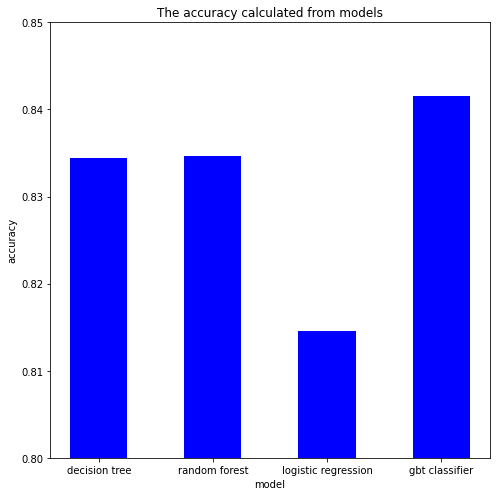

In [46]:
# Prepare the data
accuracy = [dt_accuracy, rf_accuracy, lr_accuracy, gbt_accuracy]
model = ['decision tree', 'random forest', 'logistic regression', 'gbt classifier']
width = 0.5

# Plot the data
plt.figure(figsize = (7,7))
plt.bar(model, accuracy, width, align = 'center', color = 'blue')

plt.xticks(model)
plt.ylim(0.8, 0.85)
plt.xlabel('model')
plt.ylabel('accuracy')
plt.title('The accuracy calculated from models')
plt.tight_layout()
plt.show()

## Step 9: Calculate the confusion matrix and find the precision, recall and F1 score of each classification algorithm. Explain how the accuracy of the prediction can be improved? 

In [47]:
# Build the function to calculate the precision, recall and F1 score from the confusion matrix
def calculate_rates(confusion_matrix):
    def calculate_precision(confusion_matrix):
        return confusion_matrix[1][1]/(confusion_matrix[1][0] + confusion_matrix[1][1])
    def calculate_recall(confusion_matrix):
        return confusion_matrix[1][1]/(confusion_matrix[0][1] + confusion_matrix[1][1])
    def calculate_f1_score(confusion_matrix):
        return (2*calculate_precision(confusion_matrix)*calculate_recall(confusion_matrix))/\
    (calculate_precision(confusion_matrix) + calculate_recall(confusion_matrix))
    return calculate_precision(confusion_matrix), calculate_recall(confusion_matrix), calculate_f1_score(confusion_matrix)

In [48]:
# The list of rates
rates = ['Precision', 'Recall', 'F1 Score']

### 9.1. Calculate the confusion matrix of decision tree classifier 

In [49]:
# Create the confusion matrix including actual values and predicted values of RainTomorrow_index of Decision Tree Classifier
sub_predictions = dt_predictions.select(['RainTomorrow_index', 'prediction'])
sub_predictions = sub_predictions.rdd.map(tuple)
dt_metrics = MulticlassMetrics(sub_predictions)
dt_confusion_mat = dt_metrics.confusionMatrix()
dt_confusion_mat = dt_confusion_mat.toArray()
dt_confusion_mat

array([[31362.,  5180.],
       [ 1902.,  4341.]])

In [50]:
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the Decision Tree Classifier is {1}'.format(rates[i], calculate_rates(dt_confusion_mat)[i]))

The Precision of the Decision Tree Classifier is 0.695338779432965
The Recall of the Decision Tree Classifier is 0.45593950215313517
The F1 Score of the Decision Tree Classifier is 0.5507485409794468


### 9.2.  Calculate the confusion matrix of random forest classifier

In [51]:
# Create the confusion matrix including actual values and predicted values of RainTomorrow_index of Random Forest Classifier
sub_predictions = rf_predictions.select(['RainTomorrow_index', 'prediction'])
sub_predictions = sub_predictions.rdd.map(tuple)
rf_metrics = MulticlassMetrics(sub_predictions)
rf_confusion_mat = dt_metrics.confusionMatrix()
rf_confusion_mat = rf_confusion_mat.toArray()
rf_confusion_mat

array([[31362.,  5180.],
       [ 1902.,  4341.]])

In [52]:
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the Random Forest Classifier is {1}'.format(rates[i], calculate_rates(rf_confusion_mat)[i]))

The Precision of the Random Forest Classifier is 0.695338779432965
The Recall of the Random Forest Classifier is 0.45593950215313517
The F1 Score of the Random Forest Classifier is 0.5507485409794468


### 9.3. Calculate the confusion matrix of logistic regression

In [53]:
# Create the confusion matrix including actual values and predicted values of RainTomorrow_index of Logistic Regression
sub_predictions = lr_predictions.select(['RainTomorrow_index', 'prediction'])
sub_predictions = sub_predictions.rdd.map(tuple)
lr_metrics = MulticlassMetrics(sub_predictions)
lr_confusion_mat = lr_metrics.confusionMatrix()
lr_confusion_mat = lr_confusion_mat.toArray()
lr_confusion_mat

array([[31003.,  5672.],
       [ 2261.,  3849.]])

In [54]:
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the Logistic Regression is {1}'.format(rates[i], calculate_rates(lr_confusion_mat)[i]))

The Precision of the Logistic Regression is 0.6299509001636662
The Recall of the Logistic Regression is 0.40426425795609705
The F1 Score of the Logistic Regression is 0.4924828865715566


### 9.4. Calculate the confusion matrix of GBT classifier

In [55]:
# Create the confusion matrix including actual values and predicted values of RainTomorrow_index of GBT Classifier 
sub_predictions = gbt_predictions.select(['RainTomorrow_index', 'prediction'])
sub_predictions = sub_predictions.rdd.map(tuple)
gbt_metrics = MulticlassMetrics(sub_predictions)
gbt_confusion_mat = gbt_metrics.confusionMatrix()
gbt_confusion_mat = gbt_confusion_mat.toArray()
gbt_confusion_mat

array([[31548.,  5065.],
       [ 1716.,  4456.]])

In [56]:
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the GBT Classifier is {1}'.format(rates[i], calculate_rates(gbt_confusion_mat)[i]))

The Precision of the GBT Classifier is 0.7219701879455606
The Recall of the GBT Classifier is 0.46801806532927215
The F1 Score of the GBT Classifier is 0.5678965143694641
